In [60]:
# Loading the MNIST dataset with 0 and 1 labels only

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

mnist_train = datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())

indices_train = [idx for idx, (_, label) in enumerate(mnist_train) if label in [0, 1]]
indices_test = [idx for idx, (_, label) in enumerate(mnist_test) if label in [0, 1]]

train_loader = DataLoader(mnist_train, batch_size = 100, sampler=SubsetRandomSampler(indices_train))
test_loader = DataLoader(mnist_test, batch_size = 100, sampler=SubsetRandomSampler(indices_test))


In [77]:
# Linear classifier

import torch
import torch.nn as nn
import torch.optim as optim


def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model(X.view(X.shape[0], -1))[:,0]
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


Train Err	Train Loss	Test Err	Test Loss
0.001100	0.003157	0.000100	0.000726
0.000300	0.001122	0.000100	0.000528
0.000300	0.000941	0.000100	0.000480
0.000250	0.000807	0.000100	0.000461
0.000233	0.000743	0.000100	0.000451


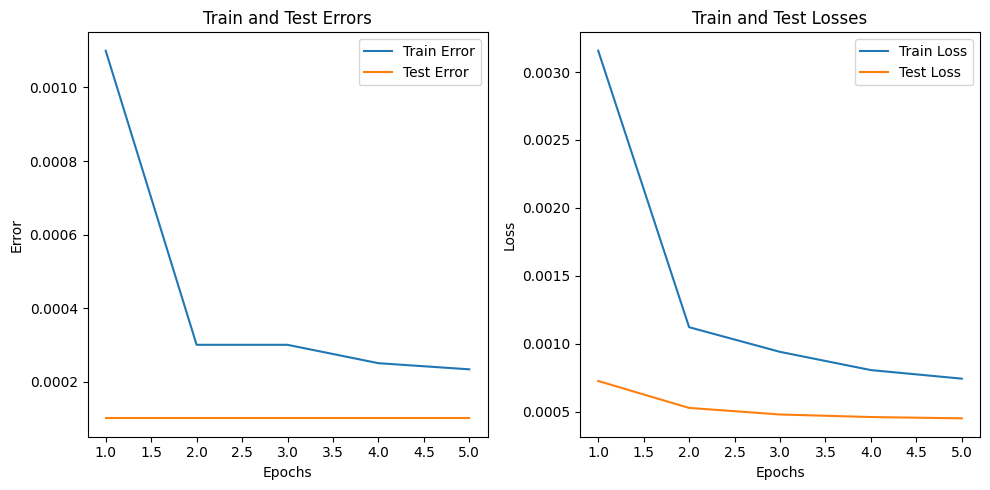

In [78]:
# Train the classifier for 10  epochs

model = nn.Linear(784, 1)
opt = optim.SGD(model.parameters(), lr=1.)
train_errors = []
train_losses = []
test_errors = []
test_losses = []

print("Train Err", "Train Loss", "Test Err", "Test Loss", sep="\t")
for i in range(5):
    train_err, train_loss = epoch(train_loader, model, opt)
    test_err, test_loss = epoch(test_loader, model)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")


    train_errors.append(train_err)
    train_losses.append(train_loss)
    test_errors.append(test_err)
    test_losses.append(test_loss)

# Plotting
epochs = range(1, len(train_errors) + 1)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_errors, label='Train Error')
plt.plot(epochs, test_errors, label='Test Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Train and Test Errors')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Losses')
plt.legend()

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'True Label: 0')

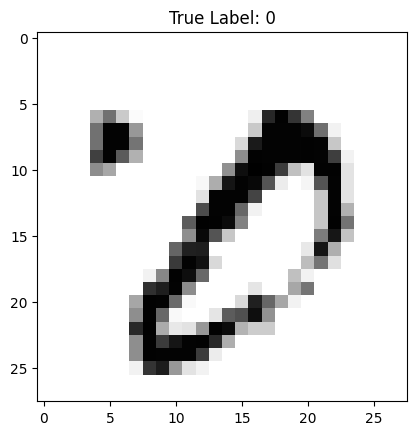

In [79]:
# Printing the example classified wrongly

import matplotlib.pyplot as plt

X_test = (test_loader.dataset.test_data.float()/255).view(len(test_loader.dataset),-1)
y_test = test_loader.dataset.test_labels
yp = model(X_test)[:,0]
idx = (yp > 0) * (y_test == 0) + (yp < 0) * (y_test == 1)
plt.imshow(1-X_test[idx][0].view(28,28).numpy(), cmap="gray")
plt.title("True Label: {}".format(y_test[idx].item()))


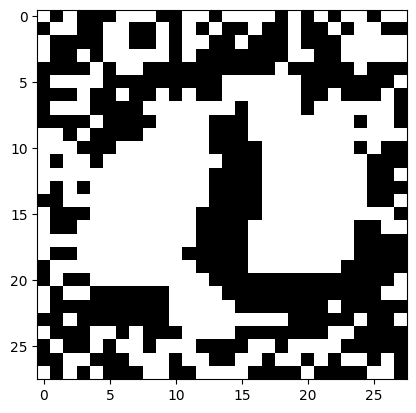

In [80]:
# Example of adversarial attack

epsilon = 0.2
delta = epsilon * model.weight.detach().sign().view(28,28)
plt.imshow(1-delta.numpy(), cmap="gray")

In [81]:
# Initiate an adversarial attack

def epoch_adv(loader, model, delta):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model((X-(2*y.float()[:,None,None,None]-1)*delta).view(X.shape[0], -1))[:,0]
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)
print(epoch_adv(test_loader, model, delta[None,None,:,:]))


(0.1641, 0.4966906545162201)


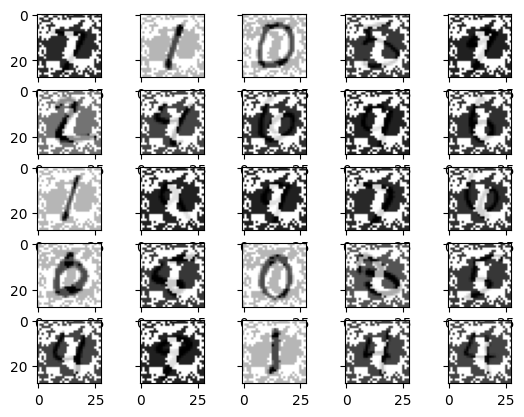

In [67]:
f,ax = plt.subplots(5,5, sharey=True)
for i in range(25):
    ax[i%5][i//5].imshow(1-(X_test[i].view(28,28) - (2*y_test[i]-1)*delta).numpy(), cmap="gray")
    ax


In [73]:
# Training robust linear models

def epoch_robust(loader, model, epsilon, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model(X.view(X.shape[0], -1))[:,0] - epsilon*(2*y.float()-1)*model.weight.norm(1)
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)



In [70]:
model = nn.Linear(784, 1)
opt = optim.SGD(model.parameters(), lr=1e-1)
epsilon = 0.2
print("Rob. Train Err", "Rob. Train Loss", "Rob. Test Err", "Rob. Test Loss", sep="\t")
for i in range(20):
    train_err, train_loss = epoch_robust(train_loader, model, epsilon, opt)
    test_err, test_loss = epoch_robust(test_loader, model, epsilon)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")


Rob. Train Err	Rob. Train Loss	Rob. Test Err	Rob. Test Loss
0.031650	0.079355	0.015500	0.046210
0.015500	0.047170	0.011000	0.035692
0.013183	0.041608	0.010100	0.034154
0.012217	0.038763	0.009500	0.033418
0.011133	0.036928	0.008100	0.028384
0.010567	0.035451	0.008400	0.028601
0.010083	0.034367	0.007200	0.026682
0.009700	0.033443	0.006800	0.025061
0.009433	0.032654	0.007000	0.025606
0.009167	0.032050	0.006800	0.025262
0.008750	0.031559	0.005700	0.023174
0.008533	0.031000	0.005700	0.023086
0.008333	0.030592	0.006000	0.024599
0.008033	0.030247	0.005800	0.022486
0.008117	0.029902	0.006000	0.024853
0.007883	0.029678	0.005500	0.023236
0.007683	0.029396	0.005700	0.023217
0.007500	0.029181	0.005200	0.021418
0.007400	0.028961	0.005400	0.022106
0.007167	0.028819	0.005100	0.021117


In [76]:
train_err, train_loss = epoch(train_loader, model)
test_err, test_loss = epoch(test_loader, model)
print("Train Err", "Train Loss", "Test Err", "Test Loss", sep="\t")
print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Train Err	Train Loss	Test Err	Test Loss
0.000167	0.000672	0.000100	0.000437


In [ ]:
# The image of the optimal perturbation for the robust model

delta = epsilon * model.weight.detach().sign().view(28,28)
plt.imshow(1-delta.numpy(), cmap="gray")
